## **Focal Loss in Semantic Segmentation: Theory, Implementation, and Comparison with Cross Entropy**

*Authors: Sahika Betul Yayli, MD*

## Introduction to Focal Loss

In medical image segmentation, detecting small structures—like aneurysms or lesions—is particularly challenging. These abnormalities often occupy **less than 1% of the scan**, making them easy to miss during training.

When using standard loss functions like **Dice** or **Cross-Entropy**, models tend to focus on the dominant background class, leading to **high false negatives** on tiny structures.

### 1. Why Focal Loss?

**Focal Loss** addresses class imbalance by:
- Giving **more weight to hard, misclassified examples**
- Reducing the impact of well-classified, easy regions

This forces the model to pay more attention to small or underrepresented areas in the image.

### 2. Is Focal Loss Enough on Its Own?

Not always. While Focal Loss reduces **false negatives**, it doesn’t explicitly optimize **segmentation boundaries** as well as **Dice Loss** does.

That’s why frameworks like **nnU-Net** combine **Dice + BCE Loss** for better shape learning. In many cases, combining **Dice + BCE + Focal** can yield more balanced and robust results.

### 3. When to Use Focal Loss

Use Focal Loss if:
- Your target structures are **very small** (e.g., aneurysms)
- Your model **misses positive regions** too often
- Standard **Dice + BCE** isn’t performing well enough

### 4. What You'll Do in This Notebook

In this notebook, we’ll:
- Implement Focal Loss in a segmentation pipeline
- Use the `VOCSegmentation` dataset from `torchvision`
- Compare its performance against standard loss functions


### 5. The Formula Behind Focal Loss

The Focal Loss modifies the standard Cross Entropy Loss by applying a factor of $(1 - p_t)^\gamma$, where:
- $p_t$ is the model’s estimated probability for the true class,  
- $\gamma$ is the **focusing parameter** that adjusts how much to down-weight easy examples.

The full formula is:

$$
\text{FL}(p_t) = -\alpha \cdot (1 - p_t)^\gamma \cdot \log(p_t)
$$

Where:
- $\alpha$ is a balancing factor between classes (optional),  
- $\gamma > 0$ focuses more on hard examples as it increases.

This mechanism helps the model learn better representations of underrepresented or difficult classes by explicitly amplifying their gradient contributions during backpropagation.

Let's now implement Focal Loss in PyTorch and compare its performance with standard Cross Entropy Loss in a segmentation setting using the **PASCAL VOC 2012** dataset.

In this study, we aim to compare the effectiveness of different loss functions in semantic segmentation:

1. Dice Only
- Uses **Dice Loss** to directly optimize for overlap between predicted and ground truth masks.
- Especially effective for segmentation tasks where shape accuracy is crucial.

2. Dice + Cross Entropy (CE)
- Combines Dice Loss with **Cross-Entropy Loss**, balancing class-level accuracy and boundary precision.
- This is the default configuration used in many frameworks like nnU-Net.

3. Focal + CE + Dice
- Adds **Focal Loss** to the mix to improve performance on small, hard-to-detect regions.
- Assigns more weight to misclassified pixels and helps in cases of class imbalance.


In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import fcn_resnet50

from IPython.display import clear_output

Before we proceed, we configure PyTorch to use the GPU if available.  

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation and Model Setup

### Preprocessing: Image and Mask Transformations

To prepare the data for training, we apply the following transformations:

- **Image Transformations**:
  - Resize all images to **128×128** for faster training.
  - Convert them to tensors using `ToTensor()`.

- **Mask Transformations**:
  - Resize using **nearest neighbor interpolation** to preserve class labels.
  - Convert PIL mask to tensor with `PILToTensor()`.
  - Remove singleton channel dimension and convert to `long` (integer class labels).

Consistent resizing ensures input-output alignment for segmentation tasks.


In [3]:
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])

### Dataset: PASCAL VOC 2012

For this notebook, we use the **PASCAL VOC 2012** segmentation dataset, a widely used benchmark in semantic segmentation.

Why this dataset?:
- **Public and accessible** via `torchvision.datasets`
- **Multi-class segmentation** with diverse object types (e.g., person, car, dog)
- Suitable for comparing loss functions in both small and large structures

Dataset Summary:
- **Train set**: 1464 images
- **Validation set**: 1449 images
- **Number of classes**: 21  
  (20 object classes + 1 background)

We wrap the dataset using a custom `VOCSegDataset` class, applying:
- Transformations for resizing and tensor conversion
- Label pre-processing for training

This setup prepares the data for use with PyTorch `DataLoader`.


In [4]:
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, root, image_set='train', transform=None, target_transform=None):
        self.voc = VOCSegmentation(root=root, year='2012', image_set=image_set, download=True)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        img, target = self.voc[idx]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            target = self.target_transform(target)
        return img, target

We split the dataset into **training** and **validation** subsets using the built-in `image_set` argument from `torchvision.datasets.VOCSegmentation`.

- `train_loader` is shuffled to help the model generalize.
- `val_loader` is not shuffled to ensure consistent evaluation.

We use a **batch size of 8** for both loaders to balance training speed and memory efficiency. Be patient, this step may take some time!

In [ ]:
# Load full 'train' set
full_train_dataset = VOCSegDataset(
    root='data',
    image_set='train',
    transform=image_transform,
    target_transform=mask_transform
)

# Calculate split lengths
total_len = len(full_train_dataset)
val_len = int(0.35 * total_len)
train_len = total_len - val_len

# Randomly split into train and val
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

### Model Selection: FCN-ResNet50

We use **FCN-ResNet50** (`fcn_resnet50`) from `torchvision.models.segmentation` as our segmentation model. Why this model?:
- FCN (Fully Convolutional Network) is a widely-used architecture for semantic segmentation.
- It’s lightweight yet effective for benchmarking segmentation tasks.
- The backbone **ResNet50** provides strong feature extraction capabilities.
- Built-in PyTorch support simplifies integration and training.

We set `pretrained=False` to train from scratch and define `num_classes=21` to match the number of segmentation classes in the PASCAL VOC dataset.

In [6]:
model = fcn_resnet50(pretrained=False, num_classes=21).to(device)

/research/projects/Sahika/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/research/projects/Sahika/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training & Evaluation

We define generic `train()` and `evaluate()` functions that:

- Handle batch-wise training and validation.
- Compute loss using the selected criterion.
- Measure segmentation performance using Intersection over Union (IoU).
- Automatically resize masks if output and label shapes differ (common in segmentation).

These functions are reusable across all models and loss setups in our experiments.

In [7]:
def train(model, loader, optimizer, criterion, device, epoch=None, total_epochs=None, name=""):
    model.train()
    total_loss = 0
    desc = f"{name} Training (Epoch {epoch}/{total_epochs})" if epoch else "Training"
    loop = tqdm(loader, desc=desc, leave=False)
    for batch in loop:
        img, mask = batch
        img, mask = img.to(device), mask.to(device)

        outputs = model(img)['out']

        # Resize mask if necessary
        if outputs.shape[-2:] != mask.shape[-2:]:
            mask = F.interpolate(mask.unsqueeze(1).float(), size=outputs.shape[-2:], mode="nearest").squeeze(1).long()

        optimizer.zero_grad()
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader)


def evaluate(model, loader, criterion, device, epoch=None, total_epochs=None, name=""):
    model.eval()
    total_loss = 0
    ious = []
    desc = f"{name} Eval (Epoch {epoch}/{total_epochs})" if epoch else "Evaluating"
    loop = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for batch in loop:
            img, mask = batch
            img, mask = img.to(device), mask.to(device)

            outputs = model(img)['out']

            # Resize mask if necessary
            if outputs.shape[-2:] != mask.shape[-2:]:
                mask = F.interpolate(mask.unsqueeze(1).float(), size=outputs.shape[-2:], mode="nearest").squeeze(1).long()

            loss = criterion(outputs, mask)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            valid = (mask != 255)
            intersection = ((preds == mask) & valid & (mask > 0)).sum().item()
            union = (((preds > 0) | (mask > 0)) & valid).sum().item()
            if union > 0:
                ious.append(intersection / union)

            loop.set_postfix(loss=loss.item())
    return total_loss / len(loader), np.mean(ious)

### Visualizing Training Progress: IoU and Loss Comparisons

To better understand the impact of different loss functions, we visualize both **Validation IoU** and **Validation Loss** across training epochs.

This dual visualization helps in comparing not just the segmentation accuracy (IoU), but also how stable and efficient the training was in terms of loss minimization.

In [18]:
def plot_history_all_models(history_dice, history_dicece, history_focaldicece):
    clear_output(wait=True)
    
    epochs = range(1, len(history_dice) + 1)

    plt.figure(figsize=(12, 4))

    # IoU Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, [h[1] for h in history_dice], label='Dice Only')
    plt.plot(epochs, [h[1] for h in history_dicece], label='Dice + CE')
    plt.plot(epochs, [h[1] for h in history_focaldicece], label='Focal + CE + Dice')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Validation IoU over Epochs')
    plt.legend()
    plt.grid(True)

    # Validation Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [h[0] for h in history_dice], label='Dice Only')
    plt.plot(epochs, [h[0] for h in history_dicece], label='Dice + CE')
    plt.plot(epochs, [h[0] for h in history_focaldicece], label='Focal + CE + Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Val Loss')
    plt.title('Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()

We define Dice and Focal loss here to train separate models and compare their performance on the same dataset.

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, ignore_index=255):
        super(DiceLoss, self).__init__()
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        mask = (targets != self.ignore_index)
        targets = torch.where(mask, targets, torch.tensor(0, device=targets.device))
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        mask = mask.unsqueeze(1).expand_as(targets)
        inputs = inputs * mask
        targets = targets * mask
        intersection = (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2. * intersection) / (union + 1e-6)
        return 1 - dice.mean()
    
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0, ignore_index=255):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

### Training Configuration and Loss Weights

In this section, we define the core training configuration:

- **Number of Epochs**: `200` — to ensure enough iterations for learning stable representations.
- **Loss Weights**:
  - `W_DICE = 1.0`: Balances shape accuracy through Dice Loss.
  - `W_CE = 1.0`: Ensures pixel-level class prediction with Cross-Entropy.
  - `W_FOCAL = 2.0`: Gives higher importance to hard-to-classify pixels, emphasizing class imbalance handling.

These weights allow us to experiment with the relative impact of each component in the total loss.


In [20]:
epochs = 200

W_DICE = 1.0
W_CE = 1.0
W_FOCAL = 2.0

In this section, we define three models using the `fcn_resnet50` architecture. Each model is trained with a different loss function setup.

Separate optimizers and loss functions are assigned to each model for independent training and evaluation.

In [21]:
# ====== Dice Only ======
model_dice = fcn_resnet50(pretrained=False, num_classes=21).to(device)
optimizer_dice = torch.optim.Adam(model_dice.parameters(), lr=1e-3)
criterion_dice = DiceLoss(ignore_index=255)


# ====== Dice + CE ======
model_dicece = fcn_resnet50(pretrained=False, num_classes=21).to(device)
optimizer_dicece = torch.optim.Adam(model_dicece.parameters(), lr=1e-3)
criterion_ce_dice = nn.CrossEntropyLoss(ignore_index=255)
criterion_dice_dice = DiceLoss(ignore_index=255)

def dice_ce_loss(inputs, targets):
    return W_DICE * criterion_dice_dice(inputs, targets) + W_CE * criterion_ce_dice(inputs, targets)

# ====== focaldicece: Focal + CE + Dice ======
model_focaldicece = fcn_resnet50(pretrained=False, num_classes=21).to(device)
optimizer_focaldicece = torch.optim.Adam(model_focaldicece.parameters(), lr=1e-3)
criterion_ce = nn.CrossEntropyLoss(ignore_index=255)
criterion_focal = FocalLoss(ignore_index=255)
criterion_dice_focaldicece = DiceLoss(ignore_index=255)

def focaldicece_loss(inputs, targets):
    return (
        W_DICE * criterion_dice_focaldicece(inputs, targets) +
        W_CE * criterion_ce(inputs, targets) +
        W_FOCAL * criterion_focal(inputs, targets)
    )

### Training and Evaluation Loop

Each model is trained over a number of epochs. During every epoch:

- Models are trained and validated separately using their assigned loss functions.
- Best-performing models (based on validation IoU) are saved.
- Validation IoU scores are plotted to compare the performance of:
  - Dice Only
  - Dice + Cross Entropy
  - Focal + Cross Entropy + Dice

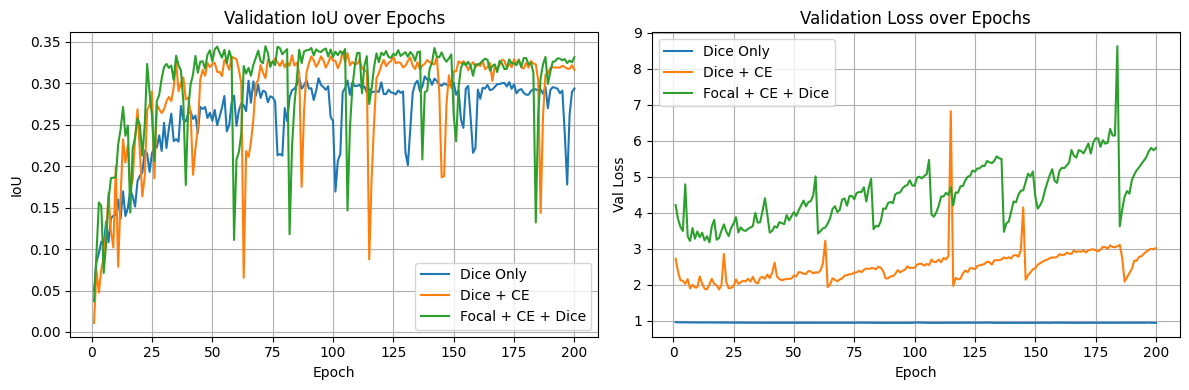

In [ ]:
history_dice = []
history_dicece = []
history_focaldicece = []
best_iou_focaldicece = 0.0
best_iou_dice = 0.0
best_iou_dicece = 0.0

for epoch in range(1, epochs + 1):
    # --- Dice Only Model ---
    train(model_dice, train_loader, optimizer_dice, criterion_dice, device, epoch, epochs, name="Dice")
    val_loss, iou = evaluate(model_dice, val_loader, criterion_dice, device, epoch, epochs, name="Dice")
    history_dice.append((val_loss, iou))

    if iou > best_iou_dice:
        best_iou_dice = iou
        torch.save(model_dice.state_dict(), "best_model_dice.pth")

    # --- Dice + CE Model ---
    train(model_dicece, train_loader, optimizer_dicece, dice_ce_loss, device, epoch, epochs, name="Dice+CE")
    val_loss, iou = evaluate(model_dicece, val_loader, dice_ce_loss, device, epoch, epochs, name="Dice+CE")
    history_dicece.append((val_loss, iou))

    if iou > best_iou_dicece:
        best_iou_dicece = iou
        torch.save(model_dicece.state_dict(), "best_model_dicece.pth")

    # --- Focal + Dice + CE Model ---
    train(model_focaldicece, train_loader, optimizer_focaldicece, focaldicece_loss, device, epoch, epochs, name="Focal+Dice+CE")
    val_loss, iou = evaluate(model_focaldicece, val_loader, focaldicece_loss, device, epoch, epochs, name="Focal+Dice+CE")
    history_focaldicece.append((val_loss, iou))

    if iou > best_iou_focaldicece:
        best_iou_focaldicece = iou
        torch.save(model_focaldicece.state_dict(), "best_model_focaldicece.pth")

    plot_history_all_models(history_dice, history_dicece, history_focaldicece)

# Testing the Models on the Test Set

Now that we have trained and saved our best-performing models, it's time to evaluate how well they generalize.

In this section, we will:
- Load the best saved weights for each model,
- Run inference on the **test set**, and
- Compare the **IoU scores** across all models to assess performance.

This comparison will help us understand the practical impact of different loss function combinations on segmentation quality. Let's start with loading trained models.

In [ ]:
model_dice.load_state_dict(torch.load("best_model_dice.pth"))
model_dicece.load_state_dict(torch.load("best_model_dicece.pth"))
model_focaldicece.load_state_dict(torch.load("best_model_focaldicece.pth"))

<All keys matched successfully>

We load a separate test set using the `VOCSegDataset` class with `image_set='test'`. This allows us to evaluate the final models on unseen data and compare class-wise IoU performance. Be patient, this step may take some time!

In [ ]:
test_dataset = VOCSegDataset(root='data', image_set='val', transform=image_transform, target_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

The function below is used to evaluate trained models on the test set.  
It calculates the **average loss** and **mean Intersection over Union (IoU)**, while ignoring void pixels (label `255`) and resizing masks if necessary.

In [25]:
def test_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    ious = []
    with torch.no_grad():
        for img, mask in tqdm(loader, desc="Testing"):
            img, mask = img.to(device), mask.to(device)
            outputs = model(img)['out']

            # Resize mask if needed
            if outputs.shape[-2:] != mask.shape[-2:]:
                mask = F.interpolate(mask.unsqueeze(1).float(), size=outputs.shape[-2:], mode="nearest").squeeze(1).long()

            loss = criterion(outputs, mask)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            valid = (mask != 255)
            intersection = ((preds == mask) & valid & (mask > 0)).sum().item()
            union = (((preds > 0) | (mask > 0)) & valid).sum().item()
            if union > 0:
                ious.append(intersection / union)

    return total_loss / len(loader), np.mean(ious)

We now run the evaluation on the test set using the best checkpoints of each model.

The results include both the average **loss** and **IoU**.

In [26]:
loss_dice_test, iou_dice_test = test_model(model_dice, test_loader, criterion_dice, device)
loss_dicece_test, iou_dicece_test = test_model(model_dicece, test_loader, dice_ce_loss, device)
loss_focaldicece_test, iou_focaldicece_test = test_model(model_focaldicece, test_loader, focaldicece_loss, device)

Testing:   0%|          | 0/182 [00:00<?, ?it/s]

Testing:   0%|          | 0/182 [00:00<?, ?it/s]

Testing:   0%|          | 0/182 [00:00<?, ?it/s]

## Test Set Performance Comparison

The following bar chart compare the **IoU** metrics across the three different loss function strategies evaluated on the test set.

This plot clearly show how incorporating Focal Loss affects model performance on challenging segmentation tasks.

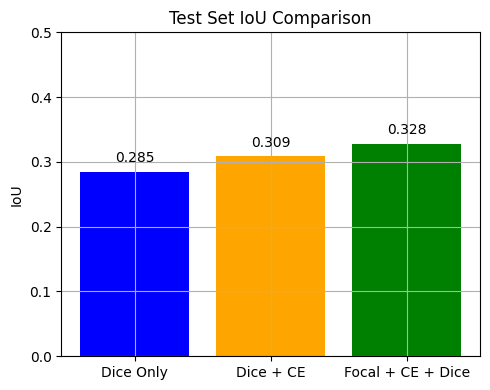

In [27]:
methods = ['Dice Only', 'Dice + CE', 'Focal + CE + Dice']
ious = [iou_dice_test, iou_dicece_test, iou_focaldicece_test]

plt.figure(figsize=(5, 4))

bars = plt.bar(methods, ious, color=['blue', 'orange', 'green'])
plt.ylabel('IoU')
plt.title('Test Set IoU Comparison')
plt.ylim(0, 0.5)
plt.grid(True)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
             f'{height:.3}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Class Based Comparison of IoU

To better understand the strengths and weaknesses of each model, we now evaluate their performance **per class** using the PASCAL VOC 2012 categories.

The VOC dataset includes 21 semantic classes:

In [28]:
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

We define a helper function `compute_class_iou` to calculate the **Intersection over Union (IoU)** score for each class individually.

This function:
- Iterates over the dataset
- Predicts segmentation maps for each image
- Calculates the intersection and union between predictions and ground truth for every class
- Returns an array of class-wise IoU scores

This is especially useful when analyzing performance on rare or small classes.


In [29]:
def compute_class_iou(model, dataloader, device):
    model.eval()
    num_classes = 21
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Computing Class-wise IoU"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)

            for cls in range(num_classes):
                pred_inds = (preds == cls)
                target_inds = (masks == cls)
                valid_mask = (masks != 255)

                inter = (pred_inds & target_inds & valid_mask).sum().item()
                uni = ((pred_inds | target_inds) & valid_mask).sum().item()

                intersection[cls] += inter
                union[cls] += uni

    class_iou = intersection / (union + 1e-8)
    return class_iou

We now compute the **per-class IoU** for all three models using the test set:

1. **Model Loading**: We load each model from its respective checkpoint path.
2. **Inference**: For each model, we perform inference on the test set.
3. **Per-Class IoU Calculation**: Using `compute_class_iou`, we calculate the IoU score for each of the 21 classes.

This comparison allows us to see **which model performs better on which object categories**, especially useful when evaluating improvement on underrepresented classes.

The results are stored in `ious_dict`, with model names as keys and corresponding class-wise IoU arrays as values.


In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model paths
paths = {
    "Dice Only": "best_model_dice.pth",
    "Dice + CE": "best_model_dicece.pth",
    "Focal + CE + Dice": "best_model_focaldicece.pth"
}

ious_dict = {}

for name, path in paths.items():
    model = fcn_resnet50(pretrained=False, num_classes=21).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    class_iou = compute_class_iou(model, test_loader, device)
    ious_dict[name] = class_iou


Computing Class-wise IoU:   0%|          | 0/182 [00:00<?, ?it/s]

Computing Class-wise IoU:   0%|          | 0/182 [00:00<?, ?it/s]

Computing Class-wise IoU:   0%|          | 0/182 [00:00<?, ?it/s]

In this section, we visualize the **per-class Intersection over Union (IoU)** 

This breakdown is especially useful for identifying improvements on small or hard-to-segment classes.

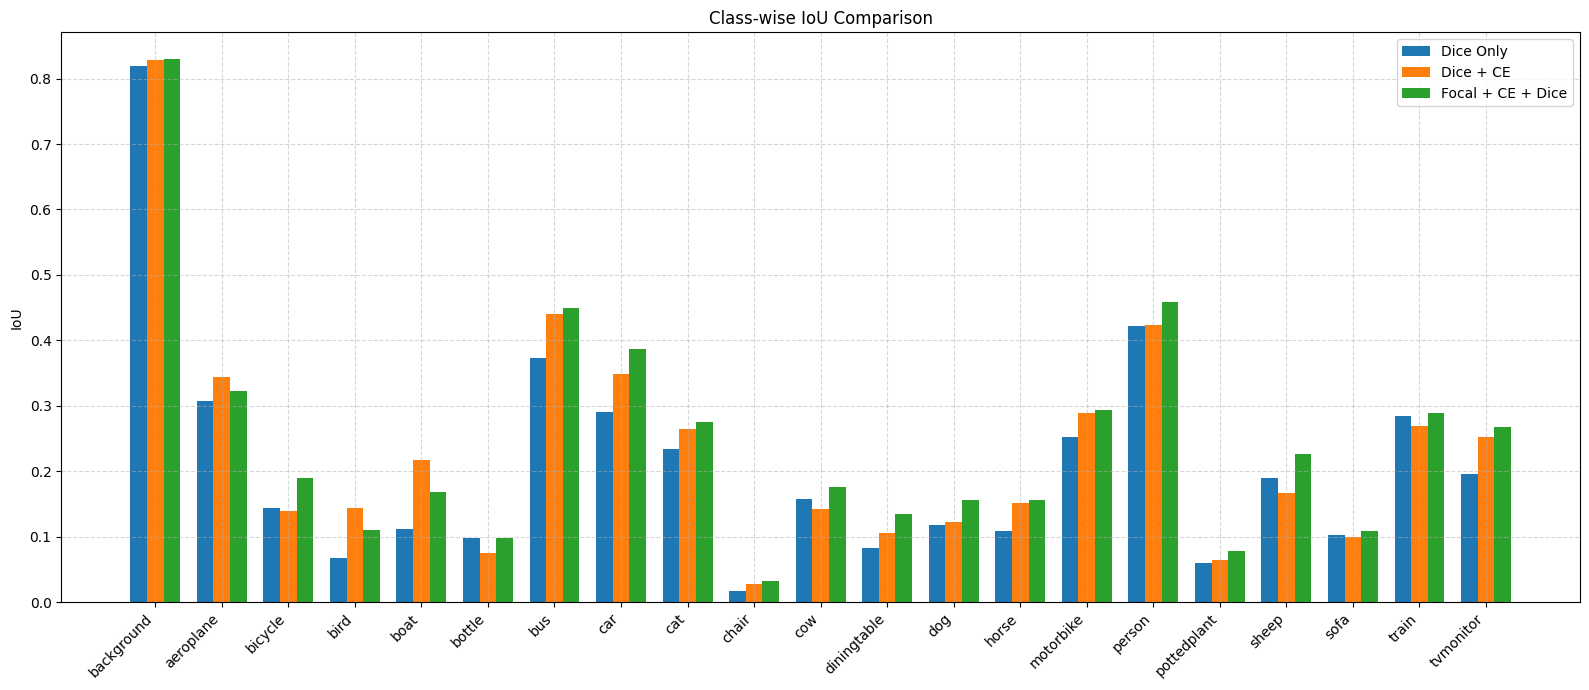

In [31]:
x = np.arange(len(VOC_CLASSES))
bar_width = 0.25

plt.figure(figsize=(16, 7))
for idx, (name, ious) in enumerate(ious_dict.items()):
    plt.bar(x + idx * bar_width, ious, width=bar_width, label=name)

plt.xticks(x + bar_width, VOC_CLASSES, rotation=45, ha="right")
plt.ylabel("IoU")
plt.title("Class-wise IoU Comparison")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Hyperparameter Tuning for Focal Loss

Tuning Focal Loss is essential for maximizing its effectiveness:

- **Gamma (γ)** — Focuses the loss on hard examples.
  - Common values: **1.0**, **2.0**, **3.0**
  - Higher γ → More emphasis on misclassified or minority pixels
- **Alpha (α)** — Balances the contribution of each class.
  - Use class-specific α if the dataset is highly imbalanced.
  - In this notebook, we used **γ = 2.0** and **α = 1.0**, which worked reasonably well for the VOC dataset.

# Conclusion & Final Thoughts

In this notebook, we explored the role of **Focal Loss** in addressing class imbalance in semantic segmentation tasks, particularly for datasets like **PASCAL VOC 2012**, which include both large and small object classes.

## Key Results & Observations

- **Focal + CE + Dice** achieved the highest overall IoU on the test set (**0.328**), outperforming Dice Only (**0.285**) and Dice + CE (**0.309**).
- Except for a few classes such as `aeroplane`, `bird`, and `boat`, the **Focal-based model achieved the best IoU scores across most object categories**, especially improving performance for smaller and underrepresented classes.
- In common or dominant categories like `background` and `person`, all three models showed similar performance — indicating that **Focal Loss provides its main benefits in minority or hard-to-learn classes**.
- The combined use of **Focal, Dice, and CE losses** resulted in a **more balanced and robust training signal**, improving segmentation performance without sacrificing generalization.

## It's Your Turn!

This notebook was designed as a learning guide.  
Now it’s your turn to experiment, adapt, and innovate with what you've built. ✨

If you're interested in extending what you've learned in this notebook, here are some meaningful directions to explore:

- **Apply to medical image segmentation:**  
  Try using this loss combination on **medical datasets** such as brain tumor, lung nodule, or vessel segmentation — where detecting **small, imbalanced regions** is often crucial for model success.

- **Experiment with advanced architectures:**  
  Integrate the same loss strategies into models like **DeepLabV3**, **UNet++**, or **Vision Transformers (e.g., Segmenter, TransUNet)** to observe how architecture influences class-wise performance.

- **Explore more complex segmentation tasks:**  
  Move beyond semantic segmentation into **instance** or **panoptic segmentation**, where class imbalance and boundary precision become even more challenging — and focal loss may be even more valuable.

# References
> T.-Y. Lin, P. Goyal, R. Girshick, K. He, and P. Dollár,  
> **"Focal Loss for Dense Object Detection,"**  
> *2017 IEEE International Conference on Computer Vision (ICCV)*, Venice, Italy, 2017, pp. 2999–3007.  
> DOI: [10.1109/ICCV.2017.324](https://doi.org/10.1109/ICCV.2017.324)